# Семантическая Сегментация.

In [1]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")


import os
import skimage.io as io
import numpy as np
from PIL import Image

import tensorflow as tf
import matplotlib.pyplot as plt
from pycocotools.coco import COCO

#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
COCO_ROOT = './data/'

tf.__version__


Bad key savefig.frameon in file C:\Users\rost_\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file C:\Users\rost_\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file C:\Users\rost_\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log filename, sys.stdout or sys.stderr')
You probably need to get an updated matplotlibrc fil

'2.1.0'

## Универсальный класс Dataset для сегментации

In [2]:
class Dataset():

    def crop_images(self, img, inp_size, random_crop=False):
        shape = tf.shape(img)
        
        pad = (
            [0, tf.maximum(inp_size - shape[0], 0)],
            [0, tf.maximum(inp_size - shape[1], 0)],
            [0, 0],
        )
        img = tf.pad(img, pad)

        if random_crop:
            img = tf.image.random_crop(img, (inp_size, inp_size, shape[2]))
        else: # central crop
            shape = tf.shape(img)
            ho = (shape[0] - inp_size) // 2
            wo = (shape[1] - inp_size) // 2
            img = img[ho:ho+inp_size, wo:wo+inp_size, :]

        return img

    def train_dataset(self, batch_size, epochs, inp_size):

        def item_to_images(item):
            random_crop = True
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.shuffle(buffer_size=len(self.img_list))
        dataset = dataset.map(item_to_images)
        dataset = dataset.repeat(epochs)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

    def val_dataset(self, batch_size, inp_size):

        def item_to_images(item):
            random_crop = False
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.map(item_to_images)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

## Класс для сегментационного датасета COCO
Класс наследутся от универсльного `Dataset` и реализует кастомную функцию чтения данных.

In [3]:
class COCO_Dataset(Dataset):

    def __init__(self, sublist):
        ann_file_fpath = os.path.join(COCO_ROOT, 'annotations', 'instances_'+sublist+'2017.json')
        self.coco = COCO(ann_file_fpath)
        self.cat_ids = self.coco.getCatIds(catNms=['person'])
        self.img_list = self.coco.getImgIds(catIds=self.cat_ids)

    def read_images(self, img_id):
        img_id = int(img_id.numpy())
        img_data = self.coco.loadImgs(img_id)[0]
        img_fname = '/'.join(img_data['coco_url'].split('/')[-2:])

        img = io.imread(os.path.join(COCO_ROOT, img_fname))
        if len(img.shape) == 2:
            img = np.tile(img[..., None], (1, 1, 3))

        ann_ids = self.coco.getAnnIds(imgIds=img_data['id'], catIds=self.cat_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        mask_class = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for i in range(len(anns)):
            mask_class += self.coco.annToMask(anns[i])
        mask_class = (mask_class > 0).astype(np.uint8)

        h = img.shape[0]
        w = img.shape[1]

        scale_k = h/200
        h = 200
        w = int(w/scale_k)

        new_image = Image.fromarray(img)
        new_image = new_image.resize((w, h))        
        new_image = np.array(new_image)

        mask = mask_class[..., None]
        new_mask = np.concatenate([mask, mask, mask], axis=2)



        new_mask = Image.fromarray(new_mask)
        new_mask = new_mask.resize((w, h))        
        new_mask = np.array(new_mask)

        n_mask = np.reshape(new_mask[:,:,0],(new_mask.shape[0], new_mask.shape[1], 1))
        img_combined = np.concatenate([new_image, n_mask], axis=2)

        return img_combined

In [4]:
COCO_dataset_train = COCO_Dataset('train')
COCO_dataset_val = COCO_Dataset('val')

loading annotations into memory...
Done (t=14.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.52s)
creating index...
index created!


In [5]:
batch_size = 175
epochs = 3
inp_size = 150

train_ds = COCO_dataset_train.train_dataset(batch_size, epochs, inp_size)
val_ds = COCO_dataset_val.val_dataset(batch_size, inp_size)

__Взглянем на форму наших датасетов.__

In [6]:
train_ds

<BatchDataset shapes: ((175, 150, 150, None), (175, 150, 150, None)), types: (tf.float32, tf.float32)>

In [7]:
val_ds

<BatchDataset shapes: ((175, None, None, None), (175, None, None, None)), types: (tf.float32, tf.float32)>

__По не ясным мне причинам там присутствуют None. И это плохо. Попробуем добавить определенности.__

In [8]:
def reshape_ds(x,y):
    return tf.reshape(x,(batch_size,inp_size,inp_size,3)), tf.reshape(y,(batch_size,inp_size,inp_size,1))

train_ds = train_ds.map(reshape_ds)
val_ds = val_ds.map(reshape_ds)

In [9]:
train_ds

<MapDataset shapes: ((175, 150, 150, 3), (175, 150, 150, 1)), types: (tf.float32, tf.float32)>

In [10]:
val_ds

<MapDataset shapes: ((175, 150, 150, 3), (175, 150, 150, 1)), types: (tf.float32, tf.float32)>

In [11]:
class ASPPBlock(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(256, (1, 1), padding='same', activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(256, (3, 3), dilation_rate=6, padding='same', activation='relu')
        self.conv3 = tf.keras.layers.Conv2D(256, (3, 3), dilation_rate=12, padding='same', activation='relu')
        self.conv4 = tf.keras.layers.Conv2D(256, (3, 3), dilation_rate=18, padding='same', activation='relu')
        self.conv5 = tf.keras.layers.Conv2D(256, (1, 1), padding='same', activation='relu')

    def call(self, inp, is_training=False):
        out1 = self.conv1(inp)
        out2 = self.conv2(inp)
        out3 = self.conv3(inp)
        out4 = self.conv4(inp)
        out = tf.concat([out1, out2, out3, out4], axis=3)
        out = self.conv5(out)
        return out
    
class ASPPNet(tf.keras.Model):
    def __init__(self):
        super().__init__()
        
        self.conv1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.conv3 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.conv4 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.conv5 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.conv6 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.conv7 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')
        self.conv8 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')
        self.conv9 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')
        self.conv10 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')

        self.conv11 = tf.keras.layers.Conv2D(48, (1, 1), padding='same', activation='relu')
        self.conv12 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.conv13 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.conv14 = tf.keras.layers.Conv2D(1, (1, 1), padding='same', activation=None)

        self.maxpool = tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same')

        self.aspp = ASPPBlock()

    def call(self, x):

        out = self.conv1(x)
        out = self.conv2(out)
        out = self.maxpool(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.maxpool(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out_enc_mid = out
        out = self.maxpool(out)
        out = self.conv7(out)
        out = self.conv8(out)
        out = self.maxpool(out)
        out = self.conv9(out)
        out = self.conv10(out)

        out = self.aspp(out)

        out = tf.image.resize(out, tf.shape(out_enc_mid)[1:3], tf.image.ResizeMethod.BILINEAR)

        out_enc_mid = self.conv11(out_enc_mid)

        out = tf.concat([out, out_enc_mid], axis=3)

        out = self.conv12(out)
        out = self.conv13(out)
        out = self.conv14(out)

        out = tf.image.resize(out, tf.shape(x)[1:3], tf.image.ResizeMethod.BILINEAR)
        out = tf.nn.sigmoid(out)
        return out
    
model = ASPPNet()

In [12]:
loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer='adam', loss=loss)

hist = model.fit(train_ds, validation_data=val_ds)

#plt.plot(hist.history['loss'])
#plt.plot(history.history['val_loss'])

Train for 1099 steps, validate for 15 steps
1099/1099 [==============================] - 4040s 4s/step - loss: 0.3017 - val_loss: 0.2263


In [13]:
model.evaluate(val_ds)

15/15 [==============================] - 35s 2s/step - loss: 0.2263


0.22629041771094005

## Пример результата сегментации

In [14]:
img = val_ds.take(1)
batch_data = img.as_numpy_iterator()
np_array_batch_data=list(batch_data)
print(np_array_batch_data[0][0].shape, np_array_batch_data[0][1].shape)

pic = np_array_batch_data[0][0][0]
label = np_array_batch_data[0][1][0]

out = model.predict(img) 
pred_mask = out[0]

(175, 150, 150, 3) (175, 150, 150, 1)


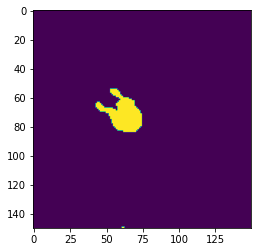

In [15]:
_=plt.imshow(label)

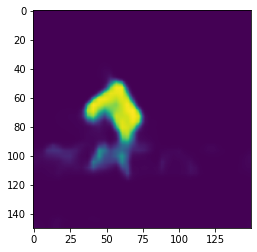

In [16]:
_=plt.imshow(pred_mask)

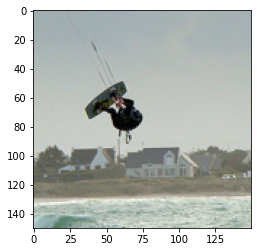

In [17]:
_=plt.imshow(pic)

## Наложение карты сегментации на изображение

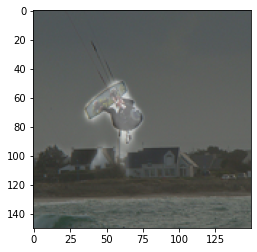

In [18]:
plt.imshow(pic*0.5 + pred_mask*0.5)
plt.show()

In [19]:
hist.history

{'loss': [0.30166984834217614], 'val_loss': [0.22629041771094005]}